In [109]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

In [187]:
#*********************************************************************************************************************
#*********************************************************************************************************************
class Node():
    
    def __init__(self, node_type = 'Node', side=None, feature = None, split_value = None, parent=None, *, node_depth = None,  ID = None, value = None, children=[]): #class initialization
        self.node_type = node_type #Leaf or Node        
        self.side = side #LEft or Right
        self.feature = feature
        self.split_value = split_value
        self.parent = parent
        
        self.node_depth = node_depth 
        self.ID = ID
        self.value = value #only for Leaf  
        self.children = []
        
            
        
        
    def add_child(self, new_value):
        self.children.append(new_value)
#*********************************************************************************************************************
#*********************************************************************************************************************

class MyTreeClf():
    
    def __init__(self, max_depth = 5,  min_samples_split =2, max_leafs = 20, bins = None): 
        self.max_depth = max_depth #maximum possible depth of tree
        self.min_samples_split = min_samples_split #minimum sample split
        self.max_leafs = max_leafs #maximum possible number of leaves in a tree
        self.bins = bins
        
        #tree parameters
        self.tree = []
        self.leafs_cnt = 0 #number of created leaves in the tree
        self.potential_leafs_cnt = 1 #counting potential leaves
        self.leafs_sum = 0 #sum of the leaves values
        
        self.histogram = {}
        
    def __repr__(self):
        return f'MyTreeClf class: max_depth={self.max_depth}, min_samples_split={self.min_samples_split}, max_leafs={self.max_leafs}'
    
    #------------------------------------------------------------------------------------------------------------
    def fit(self, X, y): #receives panda dataframe and series
        if self.bins != None:
            for feature in X.columns:
                self.histogram.update({feature: self.get_hist_delimeters(X[feature].values)})
        
        #Create root node
        feature, split_value, ig = self.get_best_split(X,y)
        X_left, y_left, X_right, y_right = self.split_dataframe(X, y, feature, split_value)
        if ig == 0.0 or len(y_left) == 0 or len(y_right) == 0:            
            print('All targets belong to class:', np.sum(y.values)/len(y.values) )
        else:
            _node = self.register_Node("Node", None, feature, split_value, None, y)
            self.grow_tree(X_left, y_left, 'Left', _node)
            self.grow_tree(X_right, y_right, 'Right', _node)
            
        
    def grow_tree(self, X, y, side, parent): #receives panda dataframe and series, string and Node
        feature, split_value, ig = self.get_best_split(X,y)
        X_left, y_left, X_right, y_right = self.split_dataframe(X, y, feature, split_value)
        
        if ig != 0.0 and len(y_left) != 0 and len(y_right) != 0 and (parent.node_depth < self.max_depth) and (len(y.values) >= self.min_samples_split) and (self.leafs_cnt + self.potential_leafs_cnt < self.max_leafs):
            _node = self.register_Node('Node', side, feature, split_value, parent, y)
            self.grow_tree(X_left, y_left, 'Left', _node)
            self.grow_tree(X_right, y_right, 'Right', _node)
        else:
            _node = self.register_Node('Leaf', side, feature, split_value, parent, y)
            return _node
            
    #-------------------------------------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------------------------------
    def register_Node(self, node_type, side, feature, split_value, parent, y):
        #1.setting node depth
        if parent != None:
            node_depth = parent.node_depth +1
        else:
            node_depth = 1
            
        #2.setting node ID
        if node_type == 'Node':
            if side == 'Left':
                 ID = parent.ID + '.1' 
            elif side == 'Right':
                 ID = parent.ID + '.2'
            else:
                ID = '1'
        
        if node_type == 'Leaf':
            ID = parent.ID
            
        #3.Setting node value
        if node_type == 'Leaf':
            value = np.sum(y.values)/len(y.values)
        else:
            value = None
        
        new_node = Node(node_type, side, feature, split_value, parent, node_depth=node_depth, ID=ID, value=value)
        self.tree.append(new_node)
        
        #add as a child to parent node
        if parent != None :                            
            parent.add_child(new_node)
            
        #update counts
        if node_type == "Node":
            self.potential_leafs_cnt = self.potential_leafs_cnt + 1
        elif node_type == "Leaf":
            self.leafs_cnt = self.leafs_cnt + 1
            self.potential_leafs_cnt = self.potential_leafs_cnt - 1
            self.leafs_sum = self.leafs_sum + value
        return new_node
        
            
    def print_tree_full(self):
        for node in self.tree:
                print(node.__dict__)
    
    def print_tree(self):
        for node in self.tree:
            if node.node_type == 'Node':
                
                print(node.__dict__['ID'], node.__dict__['feature'], '>', node.__dict__['split_value'])
            else:
                print(node.__dict__['ID'],node.__dict__['side'], '-', node.__dict__['value'])
                
    def move_up_the_tree(self, X, _node,i):
        if _node.node_type =='Leaf':
            self.predictions[i]=float(_node.value)
        elif _node.node_type =='Node': 
            if X[_node.feature] <= _node.split_value:
                if _node.children[0].side =='Left':
                    self.move_up_the_tree(X, _node.children[0],i)
                else: self.move_up_the_tree(X, _node.children[1],i)
               
            else:
                if _node.children[0].side =='Right':
                    self.move_up_the_tree(X, _node.children[0],i)
                else: self.move_up_the_tree(X, _node.children[1],i)
    #-------------------------------------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------------------------------
    def predict_proba(self,X):
        self.predictions = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            self.move_up_the_tree(X.iloc[i,:], self.tree[0],i)
        return(self.predictions)
            
    def predict(self,X):
        self.predict_proba(X)
        return (self.predictions > 0.5)*1 
    #-------------------------------------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------------------------------
    #Calculate the best split
    
    def entropy(self, y): # receives 1D numpy array
        p1 = len(y[y == 0])/len(y)
        p2 = len(y[y == 1])/len(y)
        if p1 == 0 or p2 == 0:
            return 0.0
        else:
            return -p1*np.log2(p1) - p2*np.log2(p2)

    def data_split(self, X, y, threshold): #receives two 1D numpy arrays and a float
        X_left = X[X <= threshold]
        y_left = y[X <= threshold]
        X_right = X[X > threshold]
        y_right = y[X > threshold]
        return X_left, y_left, X_right, y_right
    
    def get_IG(self, X, y, threshold): #receives two numpy arrays and a float
        #split the data by the threshold
        _, y_left, __, y_right = self.data_split(X, y, threshold)
        if len(y_left) == 0 or len(y_right) == 0: #threshold does not split the data
            return 0.0
        else:
            S0 = self.entropy(y)
            S1 = self.entropy(y_left)*len(y_left)/len(y)
            S2 = self.entropy(y_right)*len(y_right)/len(y)
            IG = S0 - S1 -S2
            return IG
        
    def get_native_delimeters(self, X): #receives 1D numpy array
        X_unique = np.unique(np.sort(X))
        native_delimeters = [np.mean([X_unique[i-1], X_unique[i]]) for i in range(1, len(X_unique))]
        return native_delimeters
    
    def get_hist_delimeters(self, X): #receives 1D numpy array
        hist_delimeters = np.histogram(X, self.bins)[1][1:-1]
        return hist_delimeters
    
    def get_best_split(self, X, y): #receives panda dataframe and panda series
        feature_best_split = {}
        for feature in X.columns:
            if len(X[feature].values) == 0 or np.max(X[feature].values) == np.min(X[feature].values):
                feature_best_split.update({feature: [None, 0.0]}) #feature has no values or any delimeters
            else:
                if self.bins == None:                    
                    feature_delimeters = self.get_native_delimeters(X[feature].values)
                else: 
                    X_unique = np.unique(np.sort(X))
                    if len(X_unique) <= self.bins:
                        feature_delimeters = self.get_native_delimeters(X[feature].values)
                    else:
                         feature_delimeters = self.histogram[feature]
                    
                feature_igs = [self.get_IG(X[feature].values, y.values, feature_delimeters[i]) for i in range(len(feature_delimeters))]
                feature_best_split.update({feature: [feature_delimeters[np.argmax(feature_igs)],np.max(feature_igs)]})
        
        split_value, ig   = max(feature_best_split.values(), key=lambda x: x[1])
        feature = next(k for k, v in feature_best_split.items() if v == [split_value, ig])
        return feature, split_value, ig
    #-------------------------------------------------------------------------------------------------------------
        
    def split_dataframe(self, X, y, feature, threshold): #X,y - np.arrays, threshold - float
        X_left = X[X[feature] <= threshold].reset_index(drop = True)
        y_left = y[X[feature] <= threshold].reset_index(drop = True)
        X_right = X[X[feature] > threshold].reset_index(drop = True)
        y_right = y[X[feature] > threshold].reset_index(drop = True)
        return X_left, y_left, X_right, y_right   
    
        
    

In [188]:
df = pd.read_csv('banknote+authentication.zip', header=None)
df.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'target']
X, y = df.iloc[:,:4], df['target']

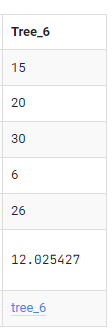

1 - variance > -0.10864999999999903

1.1 - skewness > 8.497483333333335

1.1.1 - variance > -2.4197999999999995

1.1.1.1 - curtosis > 6.32065

1.1.1.1.2 - skewness > -0.41075000000000017

1.1.1.1.2.left - 1.0

1.1.1.1.2.right - 0.0

1.1.1.1.left - 1.0

1.1.1.2 - skewness > 4.043366666666667

1.1.1.2.1 - curtosis > 6.32065

1.1.1.2.1.1 - curtosis > 2.4517333333333333

1.1.1.2.1.1.2 - skewness > -0.41075000000000017

1.1.1.2.1.1.2.left - 1.0

1.1.1.2.1.1.2.right - 0.3333333333333333

1.1.1.2.1.1.left - 1.0

1.1.1.2.1.2 - skewness > -4.864866666666666

1.1.1.2.1.2.1 - entropy > -1.2163999999999993

1.1.1.2.1.2.1.left - 0.8

1.1.1.2.1.2.1.right - 1.0

1.1.1.2.1.2.2 - skewness > -0.41075000000000017

1.1.1.2.1.2.2.left - 0.25

1.1.1.2.1.2.2.right - 0.0

1.1.1.2.right - 0.0

1.1.2 - variance > -4.73095

1.1.2.left - 1.0

1.1.2.right - 0.0

1.2 - variance > 2.2025000000000006

1.2.1 - curtosis > -1.4171833333333335

1.2.1.1 - skewness > 8.497483333333335

1.2.1.1.1 - skewness > 4.043366666666667

1.2.1.1.1.2 - entropy > -4.882299999999999

1.2.1.1.1.2.left - 1.0

1.2.1.1.1.2.right - 0.47058823529411764

1.2.1.1.1.left - 1.0

1.2.1.1.right - 0.0

1.2.1.2 - skewness > 4.043366666666667

1.2.1.2.1 - curtosis > 2.4517333333333333

1.2.1.2.1.1 - entropy > 0.6165500000000002

1.2.1.2.1.1.1 - skewness > -0.41075000000000017

1.2.1.2.1.1.1.left - 0.75

1.2.1.2.1.1.1.right - 0.3548387096774194

1.2.1.2.1.1.right - 0.9333333333333333

1.2.1.2.1.right - 0.0

1.2.1.2.right - 0.0

1.2.2 - entropy > -1.2163999999999993

1.2.2.1 - skewness > 8.497483333333335

1.2.2.1.1 - curtosis > -1.4171833333333335

1.2.2.1.1.left - 0.13333333333333333

1.2.2.1.1.right - 0.0

1.2.2.1.right - 0.0

1.2.2.right - 0.0

In [192]:
test = MyTreeClf(15,20,30,6)
test.fit(X,y)
test.print_tree()
print(test.leafs_cnt)
print(np.round(test.leafs_sum,6))
#print(np.sum(test.predict_proba()))

1 variance > -0.10864999999999903
1.1 skewness > 8.497483333333335
1.1.1 variance > -2.4197999999999995
1.1.1.1 curtosis > 6.32065
1.1.1.1 Left - 1.0
1.1.1.1.2 skewness > -0.41075000000000017
1.1.1.1.2 Left - 1.0
1.1.1.1.2 Right - 0.0
1.1.1.2 skewness > 4.043366666666667
1.1.1.2.1 curtosis > 6.32065
1.1.1.2.1.1 curtosis > 2.4517333333333333
1.1.1.2.1.1 Left - 1.0
1.1.1.2.1.1.2 skewness > -0.41075000000000017
1.1.1.2.1.1.2 Left - 1.0
1.1.1.2.1.1.2 Right - 0.3333333333333333
1.1.1.2.1.2 skewness > -4.864866666666666
1.1.1.2.1.2.1 entropy > -1.2163999999999993
1.1.1.2.1.2.1 Left - 0.8
1.1.1.2.1.2.1 Right - 1.0
1.1.1.2.1.2.2 skewness > -0.41075000000000017
1.1.1.2.1.2.2 Left - 0.25
1.1.1.2.1.2.2 Right - 0.0
1.1.1.2 Right - 0.0
1.1.2 variance > -4.73095
1.1.2 Left - 1.0
1.1.2 Right - 0.0
1.2 variance > 2.2025000000000006
1.2.1 curtosis > -1.4171833333333335
1.2.1.1 skewness > 8.497483333333335
1.2.1.1.1 skewness > 4.043366666666667
1.2.1.1.1 Left - 1.0
1.2.1.1.1.2 entropy > -4.8822999999999

In [194]:
X, y = make_classification(n_samples=150, n_features=5, n_informative=3, random_state=42)
X = pd.DataFrame(X).round(2)
y = pd.Series(y)
X.columns = [f'col_{col}' for col in X.columns]
test = X.sample(20, random_state=42)

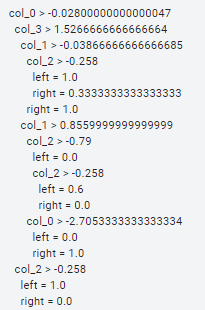

In [195]:
test_tree = MyTreeClf(8,5,15,10)
test_tree.fit(X,y)
test_tree.print_tree()
print(test_tree.leafs_cnt)
print(np.round(test_tree.leafs_sum,6))
print(np.sum(test_tree.predict_proba(test)))

1 col_0 > -0.028000000000000025
1.1 col_3 > 1.7759999999999998
1.1.1 col_1 > 0.1850000000000005
1.1.1.1 col_1 > -0.48599999999999977
1.1.1.1.1 col_2 > -0.524
1.1.1.1.1 Left - 1.0
1.1.1.1.1 Right - 0.25
1.1.1.1.2 col_4 > -0.8800000000000001
1.1.1.1.2 Left - 0.0
1.1.1.1.2 Right - 1.0
1.1.1 Right - 1.0
1.1.2 col_0 > -0.5300000000000002
1.1.2.1 col_4 > -0.38500000000000023
1.1.2.1 Left - 1.0
1.1.2.1.2 col_1 > 1.5270000000000001
1.1.2.1.2.1 col_4 > 0.10999999999999988
1.1.2.1.2.1.1 col_2 > -0.524
1.1.2.1.2.1.1 Left - 0.5
1.1.2.1.2.1.1 Right - 0.0
1.1.2.1.2.1 Right - 0.0
1.1.2.1.2 Right - 1.0
1.1.2 Right - 1.0
1.2 col_2 > -0.125
1.2 Left - 1.0
1.2 Right - 0.0
13
7.75
11.25
